**Table of contents**<a id='toc0_'></a>    
- [Mise en place](#toc1_)    
  - [Récupération des données et requête SQL](#toc1_1_)    
- [Nettoyage des données](#toc2_)    
  - [Termes spécifiques](#toc2_1_)    
  - [Processus](#toc2_2_)    
  - [Titres](#toc2_3_)    
  - [Corps de texte](#toc2_4_)    
  - [Suppression des lignes vides](#toc2_5_)    
  - [Document](#toc2_6_)    
  - [Données pré-traitées](#toc2_7_)    
- [Vocabulaire](#toc3_)    
  - [Titres](#toc3_1_)    
  - [Corps](#toc3_2_)    
  - [Vocabulaire complet : corpus](#toc3_3_)    
- [Statistiques](#toc4_)    
  - [Comptage et fréquence des mots](#toc4_1_)    
  - [Quelques statistiques](#toc4_2_)    
  - [Nombre de tokens par type d'entrée](#toc4_3_)    
  - [Répartition des mots](#toc4_4_)    
  - [Répartition des tags](#toc4_5_)    
  - [Répartition des langages de programmation](#toc4_6_)    
  - [Nuages de mots](#toc4_7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=2
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Mise en place](#toc0_)

In [1]:
# OS & env
from dotenv import load_dotenv
import os
import logging

# DS
import numpy as np
import pandas as pd
import dill as pickle

# home made functions from the src folder
from src.scrap_and_clean import get_languages
from src.scrap_and_clean import bowize_doc
from src.scrap_and_clean import words_filter
from src.eda import make_autopct
from src.eda import create_df
from src.eda import count_occurrences
from src.eda import make_stat_df

# ML
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# dataviz
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# LOGGING configuration (see all outputs, even DEBUG or INFO)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

## <a id='toc1_1_'></a>[Récupération des données et requête SQL](#toc0_)

[Requête disponible sur data.stackexchange.com](https://data.stackexchange.com/stackoverflow/query/1826330/top-50k-relevant-questions), que voici en détails :

``` sql
-- select top 50k questions
SELECT TOP 50000 Title, Body, Tags, Score, AnswerCount, CreationDate, ViewCount
FROM Posts
WHERE PostTypeId = 1 -- (1 for questions)

--filter
AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5
AND Score >= 10
AND AnswerCount >= 1

ORDER BY CreationDate DESC
```

La requête est un compromis entre simplicité, qualité maximale et contraintes imposées (questions contenant au moins 5 tags, notamment) :
- pour la qualité, on utilise un **score supérieur supérieur ou égal à 10** avec **au moins 1 réponse** (une seule suffit puisque si elle est de qualité, elle peut suffire à toute la communauté dans bien des cas)
- elle reste **à spectre large** pour tout type de questions
- seules les **données indispensables et conformes au RGPD** sont retournées
- la **variable ViewCount est gardée pour étude** mais pas utilisée comme filtre
    > Elle est relativement corrélée au score, mais pas totalement par :
    > - la **différence d'usage et de comportement** : les vues indexées par les moteurs de recherche amenant de nombreux internautes vs les utilisateurs réguliers de SOF plus exigeants et/ou précis
    > - entre un **sujet très populaire et une niche** qui peuvent avoir tous deux de hauts scores mais un faible viewcount pour la niche
- à l'issue de la requête, on constate que les **dates remontent jusqu'en 2015, ce qui est très actuel** pour la plupart des sujets
    > Cela fait suite à plusieurs tests en amont :  
    > 
    > Sur l'année passée, on obtient 204 réponses à la requête avec le filtre d'au moins 5 tags, 970 sans ce filtre  
    > En changeant le filtre du score avec un score strictement supérieur à 5, on obtient 4426 réponses.
    > 
    > Plusieurs tests ont montré qu'il faut généralement du temps pour qu'une question obtienne un score de 10, selon la popularité du sujet.  
    > Cela n'enlève rien à la qualité potentielle de la question, mais il n'est pas toujours possible de s'en assurer.
    > 
    > Afin de garantir la qualité, le choix est fait d'utiliser le score bien que cela entraîne des données moins récentes.  
    > Les dates remontent jusqu'en 2015, ce qui est tout à fait cohérent au vu des cycles de vie des langages et de production informatique, tout autant que pour la problématique métier qui cherche à aider les nouveaux utilisateurs à partir des usages d'utilisateurs expérimentés.  
- la consigne préconisant un filtre des questions "mises en favori ou jugées pertinentes par les internautes" a été écartée : les **mises en favoris ne semblent plus utilisés** par les internautes et cela entraîne un filtre radical : le score est adopté pour juger de la pertinence

Le résultat de la requête est un fichier CSV de 106Mo.  
Ses données étant ignorées du versionnage, elles seront téléchargées si absentes du dossier :

In [2]:
load_dotenv()
DATA_URL = os.getenv("DATA_URL")
if not os.path.exists("data/data_raw.pkl"):
    print(f"Loading data from {DATA_URL} ...")
    df_raw = pd.read_csv(DATA_URL)
    with open("data/data_raw.pkl", "wb") as f:
        pickle.dump(df_raw, f)
else:
    with open("data/data_raw.pkl", "rb") as f:
        df_raw = pickle.load(f)

Visualisation des données brutes :

In [3]:
df = df_raw.copy()
df

,Title,Body,Tags,Score,AnswerCount,CreationDate,ViewCount
0,ITMS-91053: Missing API declaration - Privacy,<p>Why am I all of a suddent getting this on s...,<ios><app-store><plist><appstore-approval><pri...,24,7,2024-03-14 22:55:18,3092
1,Why is builtin sorted() slower for a list cont...,<p>I sorted four similar lists. List <code>d</...,<python><algorithm><performance><sorting><time...,28,2,2024-03-05 15:21:50,2699
2,std::shared_mutex::unlock_shared() blocks even...,<p>My team has encountered a deadlock that I s...,<c++><windows><multithreading><stl><shared-lock>,26,5,2024-03-01 23:09:59,1388
3,Did the rules for nullptr init of unique_ptr c...,<p>This code compiles with MSVC from VS 2022 i...,<c++><visual-c++><language-lawyer><unique-ptr>...,15,1,2024-02-22 11:29:42,490
4,Where is the order in which ELF relocations ar...,<p>Consider the following two files on a Linux...,<c++><elf><dynamic-linking><abi><relocation>,16,1,2024-02-19 21:42:03,1746
...,...,...,...,...,...,...,...
49995,Reverse engineer assembly code to c code,<p>I think this is actually a pretty simple pr...,<c><assembly><reverse-engineering><x86-64><con...,10,3,2015-02-12 23:51:30,6771
49996,Combining random forest models in scikit learn,"<p>I have two RandomForestClassifier models, a...",<python><python-2.7><scikit-learn><classificat...,21,2,2015-02-12 23:11:56,13071
49997,How can I get the primary color from my app th...,"<p>In my Android java code, how can I referenc...",<android><android-xml><android-theme><android-...,28,2,2015-02-12 22:58:22,20107
49998,CORS settings for IIS 7.5,<p>How can I convert the following code for us...,<asp.net><iis><cors><web-config><iis-7.5>,12,2,2015-02-12 21:53:34,56289


# <a id='toc2_'></a>[Nettoyage des données](#toc0_)

> **Précision technique UTF-8** :  
> l'encodage par défaut de la méthode read_csv() de Pandas est 'utf-8'  
> de même que le HTMLParser utilisé pour récupérer les langages de programmation ci-après

## <a id='toc2_1_'></a>[Termes spécifiques](#toc0_)

### Tags

Transformation de la colonne en liste de termes :

In [4]:
# change Tags string to list
df["Tags"] = df["Tags"].apply(lambda x: x[1:-1].split("><")[:5])

Recencement de tous les tags utilisés dans les données (sans doublon) :

In [5]:
tags = set()
df["Tags"].apply(lambda x: tags.update(set(x)))
print(len(tags), "existing tags:\n", list(tags)[:10])

16975 existing tags:
 ['testcontainers', 'frequency', 'vue-meta', 'plpython', 'unbound', 'support-v4', 'linker-warning', 'pyobjc', 'monkeypatching', 'tbb']


### Langages de programmation issus de Wikipedia

Sur StackOverFlow, l'usage ou mention des noms de langages informatiques est très fréquent.  
Non seulement ces langages ont des syntaxes spécifiques (.QL, C++, S, C#...) **facilement éliminées** par des traitements de caractères spéciaux, mais ils sont aussi souvent **représentatifs du sujet** et font fréquemment partie des tags.

In [6]:
prog_lang = get_languages()
print(f"Found {len(prog_lang)} programming languages on Wikipedia")

Found 693 programming languages on Wikipedia


### Ensemble des termes métier

L'union des langages de programmation et des tags recencés :

In [7]:
# concatenate all specific terms
spec_terms = prog_lang | tags
print(f"Total: {len(spec_terms)} specific terms")

Total: 17545 specific terms


À laquelle s'ajoutent quelques noms de langages et framework courts issus à nouveau de [Wikipedia](https://fr.wikipedia.org/wiki/Cat%C3%A9gorie:Framework_de_programmation) pour qu'ils ne soient pas éliminés par les traitements ultérieurs : 

In [8]:
add_spec_terms = ["qt", "d3", "hoa", "kde", "s+", "hy"]

spec_terms |= set(add_spec_terms)
print(f"Total: {len(spec_terms)} specific terms")

Total: 17549 specific terms


### Stopwords

Les *stopwords* sont des termes fréquents dans un langage mais dont la présence a un impact très faible sur le sens général du texte.  
Ces mots font partie des termes exclus des textes dans la suite de l'étude.

La bibliothèque NLTK.corpus contient une liste de ces termes en anglais, qu'il est nécessaire de télécharger une première fois :

In [9]:
# nltk.download('stopwords') # only once
stopwords = set(stopwords.words("english"))
print(f"{len(stopwords)} terms\nSample: {list(stopwords)[50:80]}")

179 terms
Sample: ["you'll", 'mustn', "shan't", 'him', 'and', 'now', 'had', 'wasn', 'up', 'which', 'y', 'don', "aren't", 'so', 'where', 'because', 'he', 'them', "won't", 'than', 'ours', 'hers', 'shan', 'at', 'too', 's', "shouldn't", "wasn't", 'she', 'being']


Après plusieurs analyse des mots les plus fréquents (cf. ci-après) et n'apportant pas de sens, quelques termes additionnels peuvent directement être ajoutés :

In [10]:
add_stopwords = [
    "can't",
    "d'oh",
    "could't",
    "could'nt",
    "cound't",
    "cound'nt",
    "coulnd't",
    "cdn'ed",
    "doesn'it",
    "does't",
    "don'ts",
    "n't",
    "'nt",
    "i'ca",
    "i'ts",
    "should't",
    "want",
    "would",
    "would't",
    "might't",
    "must't",
    "need't",
    "n'th",
    "wont't",
    "non",
    "no",
    "use",
    "using",
    "usage",
    "code",
    "like",
    "issue",
    "error",
    "file",
    "files",
    "run",
    "runs",
    "create",
    "created",
]

stopwords |= set(add_stopwords)
print(f"Total: {len(stopwords)} stopwords")

Total: 217 stopwords


### Termes à la fois exclus et métier

Il peut y avoir un conflit avec des termes se trouvant à la fois dans les termes exclus et dans les termes métier ou les tags précédents (e.g. "s", qui est également un langage de programmation).

In [11]:
mutual = stopwords & spec_terms
print(f"{len(mutual)} terms: {mutual}")

11 terms: {'between', 'using', 't', 's', 'each', 'd', 'file', 'out', 'any', 'this', 'm'}


Après analyse, certains de ces termes existent dans les langages de programmation informatique et / ou dans les tags et peuvent par conséquent :
- être gardés dans les données (donc supprimés de la liste des termes exclus)
- et d'autres écartés (donc supprimés des termes spécifiques)

In [12]:
keep_set = spec_terms.copy()
exclude_set = stopwords.copy()

print(f"Keep: {len(keep_set)} terms")
print(f"Exclude: {len(exclude_set)} terms")

Keep: 17549 terms
Exclude: 217 terms


In [13]:
items_to_keep = ["d"]
keep_set, exclude_set = words_filter(items_to_keep, "add", keep_set, exclude_set)

items_to_remove = [s for s in mutual if s not in items_to_keep]
keep_set, exclude_set = words_filter(items_to_remove, "rm", keep_set, exclude_set)

### Ponctuation

La ponctuation peut aussi être supprimée des termes.  
Certaines entrées ont été ajoutées manuellement suite à de nombreux tests dans les données :

In [14]:
PUNCTUATION = [
    "'",
    '"',
    ",",
    ".",
    ";",
    ":",
    "?",
    "!",
    "+",
    "..",
    "''",
    "``",
    "||",
    "\\\\",
    "\\",
    "==",
    "+=",
    "-=",
    "-",
    "_",
    "=",
    "(",
    ")",
    "[",
    "]",
    "{",
    "}",
    "<",
    ">",
    "/",
    "|",
    "&",
    "*",
    "%",
    "$",
    "#",
    "@",
    "`",
    "^",
    "~",
]

keep_set, exclude_set = words_filter(PUNCTUATION, "rm", keep_set, exclude_set)
print(f"Keep: {len(keep_set)} terms")
print(f"Exclude: {len(exclude_set)} terms")

Keep: 17539 terms
Exclude: 256 terms


## <a id='toc2_2_'></a>[Processus](#toc0_)

On appelle *document* chaque question, ici une ligne dans le tableau de données.  
Un document contient un titre et un corps de texte.

L'ensemble des documents s'appelle le *corpus*.

3 nouvelles colonnes sont crées dans le jeu de données contenant tous les mots contenus dans chaque document, par type d'entrée (titre, corps de la question et ensemble du document).  
Ces variables s'appellent des *bags-of-words* (abrégés *BOW*).

Leur création nécessite plusieurs étapes :

### Nettoyage

#### 🚧 vérif à la fin :

La fonction `clean_string(str)` fait le nettoyage suivant (dans l'ordre) :
- enlève tout code contenu dans les balises `<code>`** (ni pertinent ni utilisable dans de l'analyse de texte)
- enlève les images contenues dans les balises `<img>`
- enlève du texte tous les tags HTML
- enlève tous les emojis
- enlève les retours à la ligne
- passe le texte en minuscules
- enlève les points de suspension
- enlève les nombres isolés (i.e. séparés par des caractères blancs)
- enlève les espaces multiples

### Tokenisation

#### 🚧 Réécrire :

⚠️ le word_tokenize de NLTK sépare "#" du mot précédent, ce qui est gênant puisqu'utilisé pour plusieurs langages informatiques, très susceptibles d'être utilisés comme tags  
une technique consiste à utiliser la bibliothèque Multi-Word Tokenizer, mais elle déforme la sortie : ("C", "#") → "C_#"  
le plus cohérent est de vérifier qu'un langage informatique avec cette configuration et de procéder à l'union des mots dans ce seul cas

> La *tokenisation* est la division d'une phrase en entités appelées *tokens* (= *jetons*) : des mots, chiffres ou symboles séparés par des caractères blancs.

#### 🚧 vérif à la fin :

La fonction `tokenize_str(str, wl, el)` permet une tokenisation nettoyée comme suit (dans l'ordre) :
- tokenisation par la bibliothèque NLTK
- re-soude les négations parfois mal séparées par NLTK (e.g. "n't" de "wasn't")
- prise en charge des dièses ou hashtags "#" lorsqu'ils font partie des langages de programmation
- suppression de la ponctuation en tête et fin de chaîne (exception du point en tête pouvant être un terme métier)
- suppression des tokens de moins de 3 caractères sauf s'ils font partie de la liste des termes métier
- suppression des termes exclus restant (stopwords, ponctuation)

### 🚧 Stemming (racinisation) et lemmatisation

- 🚧 ajouter lemmatisation & stemmatisation
- 🚧 ne garder que lemmatisation

### Retour aux chaînes de caractère

La plupart des modèles prenant en entrée une chaîne de caractères, la fin du processus est le retour à ce format, les tokens étant séparés par des espaces.

## <a id='toc2_3_'></a>[Titres](#toc0_)

Application du traitement sur les titres

In [15]:
df["title_bow"] = df["Title"].apply(
    lambda x: bowize_doc(x, keep_set, exclude_set, PUNCTUATION)
)

## <a id='toc2_4_'></a>[Corps de texte](#toc0_)

Idem sur les corps de texte

In [16]:
df["body_bow"] = df["Body"].apply(
    lambda x: bowize_doc(x, keep_set, exclude_set, PUNCTUATION)
)

## <a id='toc2_5_'></a>[Suppression des lignes vides](#toc0_)

Suppression des entrées avec titre et corps éventuellement vides

In [17]:
df = df.loc[
    (df["title_bow"].apply(lambda x: x.strip() != ""))
    | (df["body_bow"].apply(lambda x: x.strip() != "")),
]
df.shape

(50000, 9)

## <a id='toc2_6_'></a>[Document](#toc0_)

Union des titres et du corps de texte de chaque document

In [18]:
df["doc_bow"] = df["title_bow"] + " " + df["body_bow"]

## <a id='toc2_7_'></a>[Données pré-traitées](#toc0_)

### Visualisation

In [19]:
df[["Tags", "title_bow", "body_bow", "doc_bow"]]

,Tags,title_bow,body_bow,doc_bow
0,"[ios, app-store, plist, appstore-approval, pri...",itms-91053 missing api declaration privacy,suddent getting successful builds apple,itms-91053 missing api declaration privacy sud...
1,"[python, algorithm, performance, sorting, time...",builtin sorted slower list containing descendi...,sorted four similar lists list consistently ta...,builtin sorted slower list containing descendi...
2,"[c++, windows, multithreading, stl, shared-lock]",std :shared_mutex :unlock_shared blocks even t...,team encountered deadlock suspect bug windows ...,std :shared_mutex :unlock_shared blocks even t...
3,"[c++, visual-c++, language-lawyer, unique-ptr,...",rules nullptr init unique_ptr change c++23,compiles msvc c++20 mode failes c++23 mode cur...,rules nullptr init unique_ptr change c++23 com...
4,"[c++, elf, dynamic-linking, abi, relocation]",order elf relocations applied specified,consider following two linux system use_messag...,order elf relocations applied specified consid...
...,...,...,...,...
49995,"[c, assembly, reverse-engineering, x86-64, con...",reverse engineer assembly c,think actually pretty simple problem reverse e...,reverse engineer assembly c think actually pre...
49996,"[python, python-2.7, scikit-learn, classificat...",combining random forest models scikit learn,two randomforestclassifier models combine one ...,combining random forest models scikit learn tw...
49997,"[android, android-xml, android-theme, android-...",get primary color app theme,android java reference color colorprimary set ...,get primary color app theme android java refer...
49998,"[asp.net, iis, cors, web-config, iis-7.5]",cors settings iis,convert following web.config iis web.config pl...,cors settings iis convert following web.config...


### Sauvegarde

In [20]:
with open(f"data/data_preprocessed.pkl", "wb") as f:
    pickle.dump(df, f)

# <a id='toc3_'></a>[Vocabulaire](#toc0_)

Stockage des variables contenant tout le vocabulaire des titres, corps de textes et du corpus complet

## <a id='toc3_1_'></a>[Titres](#toc0_)

In [21]:
title_vocab = set()
df["title_bow"].apply(lambda x: title_vocab.update(set(x.split(" "))))
title_vocab.discard("")
print(len(title_vocab), "tokens:\n", list(title_vocab)[:10])

30966 tokens:
 ['testcontainers', 'frequency', 'javascript-only', 'irrelevant', 'b/w', 'calculating', 'web-socket', '50ms', 'leave-one-group-out', ':set']


## <a id='toc3_2_'></a>[Corps](#toc0_)

In [22]:
body_vocab = set()
df["body_bow"].apply(lambda x: body_vocab.update(set(x.split(" "))))
body_vocab.discard("")
print(len(body_vocab), "tokens:\n", list(body_vocab)[:10])

121962 tokens:
 ['testcontainers', 'frequency', 'acquire-release', 'cmake_cxx_link_flags', 'b/w', "'offline", '//developer.android.com/studio/projects/add-native-code.html', 'abstracttransactionimpl.java:175', 'url_item', '50ms']


## <a id='toc3_3_'></a>[Vocabulaire complet : corpus](#toc0_)

In [23]:
corpus_vocab = title_vocab | body_vocab
print(
    f"Total: {len(corpus_vocab)} tokens\n({len(title_vocab)} from title and {len(body_vocab)} from body)"
)

Total: 130823 tokens
(30966 from title and 121962 from body)


# <a id='toc4_'></a>[Statistiques](#toc0_)

## <a id='toc4_1_'></a>[Comptage et fréquence des mots](#toc0_)

### 🚧 expliquer CountVectorizer

Création des listes :
- tags existants
- titres des questions
- corps des questions
- corpus = titres + corps

In [24]:
tags_list = df["Tags"].apply(lambda x: " ".join(x)).to_list()
title_list = df["title_bow"].to_list()
body_list = df["body_bow"].to_list()
corpus_list = df["doc_bow"].to_list()

Comptage des mots et vectorisation **pour le corpus total**

In [25]:
count_vectorizer = CountVectorizer(token_pattern=r"\S+", dtype=np.uint16)
X_cv = count_vectorizer.fit_transform(corpus_list)
count_vectorizer.get_feature_names_out()

array(["'+add/edit", "'+fragment_version", "'-bash", ..., '�s˸8ƍ�',
       '𝐴𝐵−𝐵𝐴', '𝑣‖=0'], dtype=object)

Création du tableau statistique du corpus

In [26]:
stats_df_corpus = pd.DataFrame()
stats_df_corpus["token"] = count_vectorizer.get_feature_names_out()
stats_df_corpus["count_corpus"] = X_cv.sum(axis=0).A1.astype(np.uint16)

# count total and get frequency
tot_corpus = stats_df_corpus.count_corpus.sum()
stats_df_corpus["freq_corpus"] = np.float32(
    stats_df_corpus["count_corpus"] / tot_corpus
)

print(f"DF shape: {stats_df_corpus.shape}")
print(f"Total tokens in corpus: {tot_corpus}")
stats_df_corpus.describe()

DF shape: (130823, 3)
Total tokens in corpus: 3104378


,count_corpus,freq_corpus
count,130823.000000,1.308230e+05
mean,23.729604,7.643915e-06
std,261.279601,8.416488e-05
min,1.000000,3.221257e-07
25%,1.000000,3.221257e-07
50%,1.000000,3.221257e-07
75%,2.000000,6.442514e-07
max,20931.000000,6.742414e-03


Même opération pour les tags, les titres et le corps

In [27]:
stats_df_tags = make_stat_df(tags_list, "tags")

INFO:root:tags DF shape: (16975, 3)
INFO:root:Total tokens in tags: 250000


In [28]:
stats_df_title = make_stat_df(title_list, "title")

INFO:root:title DF shape: (30966, 3)
INFO:root:Total tokens in title: 289843


In [29]:
stats_df_body = make_stat_df(body_list, "body")

INFO:root:body DF shape: (121962, 3)
INFO:root:Total tokens in body: 2814535


Fusion des 4 tableaux en un seul

In [30]:
temp_df_cor_tag = pd.merge(stats_df_corpus, stats_df_tags, on="token", how="left")

In [31]:
temp_df_plus_title = pd.merge(temp_df_cor_tag, stats_df_title, on="token", how="left")

In [32]:
stats_df = pd.merge(temp_df_plus_title, stats_df_body, on="token", how="left")

Gestion des valeurs nulles

In [33]:
stats_df.fillna(0, inplace=True)

Remise en place des types de données originaux

In [34]:
stats_df = stats_df.astype(
    {"count_tags": "uint16", "count_title": "uint16", "count_body": "uint16"}
)

Export

In [35]:
with open(f"data/stats_df.pkl", "wb") as f:
    pickle.dump(stats_df, f)

## <a id='toc4_2_'></a>[Quelques statistiques](#toc0_)

In [36]:
print(f'Corpus contains {len(stats_df["count_corpus"])} tokens')

Corpus contains 130823 tokens


Distribution

In [37]:
stats_df.describe()

,count_corpus,freq_corpus,count_tags,freq_tags,count_title,freq_title,count_body,freq_body
count,130823.000000,1.308230e+05,130823.000000,130823.000000,130823.000000,130823.000000,130823.000000,1.308230e+05
mean,23.729604,7.643915e-06,1.549185,0.000006,2.215535,0.000008,21.514069,7.643916e-06
std,261.279601,8.416488e-05,44.449715,0.000178,23.938977,0.000083,244.160328,8.674979e-05
min,1.000000,3.221257e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,1.000000,3.221257e-07,0.000000,0.000000,0.000000,0.000000,1.000000,3.552985e-07
50%,1.000000,3.221257e-07,0.000000,0.000000,0.000000,0.000000,1.000000,3.552985e-07
75%,2.000000,6.442514e-07,0.000000,0.000000,0.000000,0.000000,2.000000,7.105970e-07
max,20931.000000,6.742414e-03,7304.000000,0.029216,2001.000000,0.006904,19626.000000,6.973088e-03


Exemple de statistiques avec le terme "c++"

In [38]:
stats_df.loc[stats_df.token == "c++"]

,token,count_corpus,freq_corpus,count_tags,freq_tags,count_title,freq_title,count_body,freq_body
34776,c++,2339,0.000753,3117,0.012468,491,0.001694,1848,0.000657


Mots apparaissant au moins 10 fois dans le corpus

In [39]:
stats_df.loc[stats_df.count_corpus > 10]

,token,count_corpus,freq_corpus,count_tags,freq_tags,count_title,freq_title,count_body,freq_body
357,'access-control-allow-origin,97,0.000031,0,0.000000,24,0.000083,73,0.000026
373,'active,12,0.000004,0,0.000000,1,0.000003,11,0.000004
382,'add,17,0.000005,0,0.000000,4,0.000014,13,0.000005
454,'android,14,0.000005,0,0.000000,5,0.000017,9,0.000003
504,'any,17,0.000005,0,0.000000,7,0.000024,10,0.000004
...,...,...,...,...,...,...,...,...,...
130383,zsh,81,0.000026,47,0.000188,24,0.000083,57,0.000020
130391,zulu,14,0.000005,0,0.000000,3,0.000010,11,0.000004
130398,zuul,72,0.000023,0,0.000000,15,0.000052,57,0.000020
130410,zxing,11,0.000004,5,0.000020,4,0.000014,7,0.000002


5 termes les plus fréquents

In [40]:
display(stats_df.sort_values(by="count_corpus", ascending=False)[:5])

,token,count_corpus,freq_corpus,count_tags,freq_tags,count_title,freq_title,count_body,freq_body
58992,get,20931,0.006742,34,0.000136,1305,0.004502,19626,0.006973
27384,app,15256,0.004914,0,0.000000,1391,0.004799,13865,0.004926
56723,following,15164,0.004885,0,0.000000,65,0.000224,15099,0.005365
126607,way,15014,0.004836,0,0.000000,691,0.002384,14323,0.005089
87192,one,14596,0.004702,0,0.000000,549,0.001894,14047,0.004991


5 termes les moins fréquents

In [41]:
display(stats_df.sort_values(by="count_corpus", ascending=True)[:5])

,token,count_corpus,freq_corpus,count_tags,freq_tags,count_title,freq_title,count_body,freq_body
65411,import/require,1,3.221257e-07,0,0.0,1,0.000003,0,0.000000e+00
76689,mat-paginator,1,3.221257e-07,0,0.0,1,0.000003,0,0.000000e+00
76688,mat-options,1,3.221257e-07,0,0.0,0,0.000000,1,3.552985e-07
76687,mat-option,1,3.221257e-07,0,0.0,0,0.000000,1,3.552985e-07
76684,mat-list-option,1,3.221257e-07,0,0.0,1,0.000003,0,0.000000e+00


Combien de tags apparaissant au moins 5 fois dans le corpus ?

In [61]:
stats_df_tags.loc[stats_df_tags["count_tags"] > 4].shape[0]

4990

5 tags les plus fréquents

In [60]:
display(stats_df_tags.sort_values(by="count_tags", ascending=False)[:5])

,token,count_tags,freq_tags
11764,python,7304,0.029216
7698,javascript,6475,0.025900
7623,java,5421,0.021684
436,android,4764,0.019056
2381,c#,3815,0.015260


In [63]:
tags_min4_df = stats_df_tags.loc[stats_df_tags["count_tags"] > 4]
tags_min4_df["token"]

2              .htaccess
3                   .net
7               .net-4.0
8               .net-4.5
10              .net-4.6
              ...       
16961                zsh
16963     zsh-completion
16965              zshrc
16968    zurb-foundation
16972              zxing
Name: token, Length: 4990, dtype: object

## <a id='toc4_3_'></a>[Nombre de tokens par type d'entrée](#toc0_)

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/

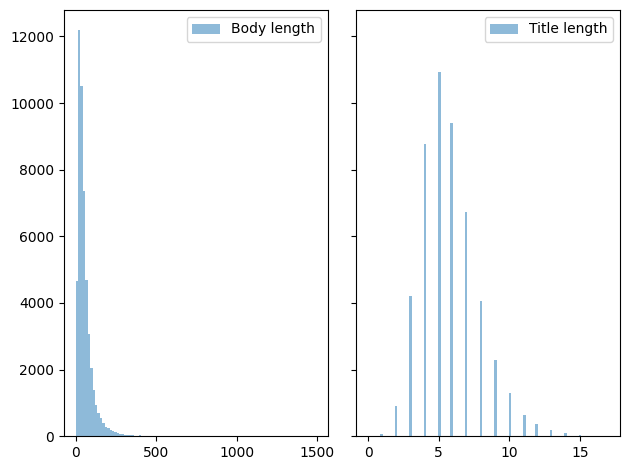

In [42]:
len_titles = []
len_bodies = []

df["title_bow"].apply(lambda x: len_titles.append(len(x.split(" "))))
df["body_bow"].apply(lambda x: len_bodies.append(len(x.split(" "))))

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(
    len_bodies,
    bins=np.linspace(0, max(len_bodies), 100),
    alpha=0.5,
    label="Body length",
)
axs[1].hist(
    len_titles,
    bins=np.linspace(0, max(len_titles), 100),
    alpha=0.5,
    label="Title length",
)
axs[0].legend(loc="upper right")
axs[1].legend(loc="upper right")

plt.show()

## <a id='toc4_4_'></a>[Répartition des mots](#toc0_)

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fnam

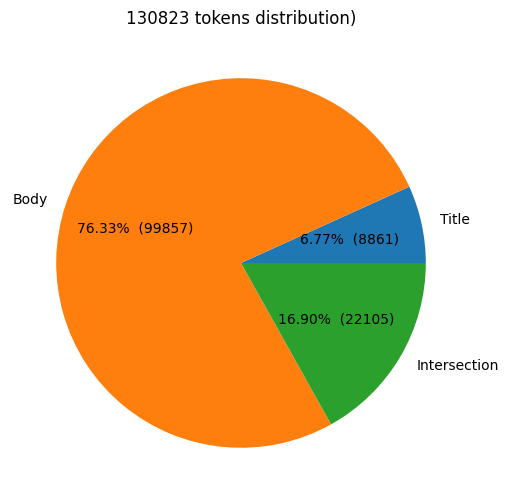

In [43]:
x = [
    len(title_vocab - body_vocab),
    len(body_vocab - title_vocab),
    len(title_vocab & body_vocab),
]

plt.figure(figsize=(6, 6))
plt.title(f"{len(corpus_vocab)} tokens distribution)")
plt.pie(
    x,
    labels=["Title", "Body", "Intersection"],
    autopct=make_autopct(x),
)

plt.show()

## <a id='toc4_5_'></a>[Répartition des tags](#toc0_)

In [44]:
missing_tags = tags - corpus_vocab

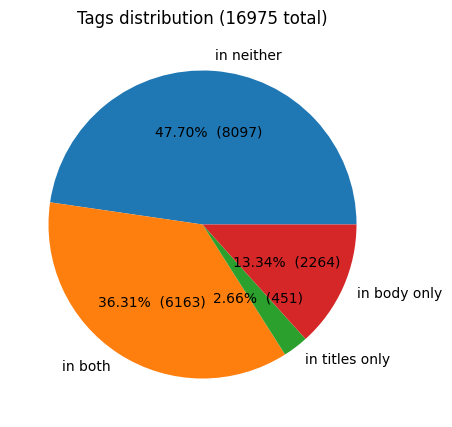

In [45]:
x = [
    len(missing_tags),
    len((tags & title_vocab) & body_vocab),
    len((tags & title_vocab) - body_vocab),
    len((tags & body_vocab) - title_vocab),
]

plt.figure(figsize=(5, 5))
plt.title(f"Tags distribution ({len(tags)} total)")
plt.pie(
    x,
    labels=["in neither", "in both", "in titles only", "in body only"],
    autopct=make_autopct(x),
)

plt.show()

Certains tags existants n'apparaissent donc ni dans les titres ni dans le corps de la question.

Plusieurs raisons à cela, notamment une suppression car ils font partie d'une ligne de code ou de liens HTML.

Voici un exemple :

In [46]:
_ = "uiresponder"

In [47]:
print(f"searching: {_}")
print(f"{_ in tags = }")
print(f"{_ in title_vocab = }")
print(f"{_ in body_vocab = }")

_df = df.loc[(df["Title"].str.contains(_)) | (df["Body"].str.contains(_))]

print(f'title:\n    {_df["Title"].values}')
print(f'body:\n    {_df["Body"].values}')

searching: uiresponder
_ in tags = True
_ in title_vocab = False
_ in body_vocab = False
title:
    ['Detect Single Modifier Key Change in UIKit for Mac (Catalyst)']
body:
    ['<p>I am porting an iOS app on MacOS using <em>UIKit for Mac</em> also known as <em>iPad Apps for Mac</em> or <em>Project Catalyst</em>.</p>\n\n<p>The app uses <a href="https://developer.apple.com/documentation/uikit/uiresponder/1621141-keycommands" rel="noreferrer"><code>keyCommands</code> from <code>UIKit</code></a> to detect a single modifier key press:</p>\n\n<pre><code>UIKeyCommand(input: "", modifierFlags: .shift, action: #selector(singleShift))\n</code></pre>\n\n<p>This code works perfectly on iPad with an external keyboard, I am getting the event fired with every single ⇧ press. However, this does not work on MacOS, although single non-modifier events and modifier + non-modifier combinations work.</p>\n\n<p>How do I achieve the desired behavior and get notified about single modifier key events?</p>\n\n<p

## <a id='toc4_6_'></a>[Répartition des langages de programmation](#toc0_)

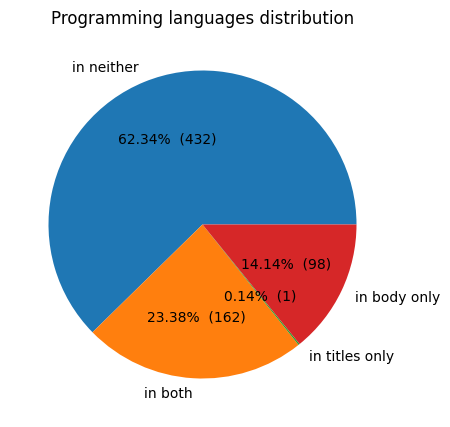

In [48]:
x = [
    len(prog_lang - title_vocab - body_vocab),
    len((prog_lang & title_vocab) & body_vocab),
    len((prog_lang & title_vocab) - body_vocab),
    len((prog_lang & body_vocab) - title_vocab),
]

plt.figure(figsize=(5, 5))
plt.title(f"Programming languages distribution")
plt.pie(
    x,
    labels=["in neither", "in both", "in titles only", "in body only"],
    autopct=make_autopct(x),
)

plt.show()

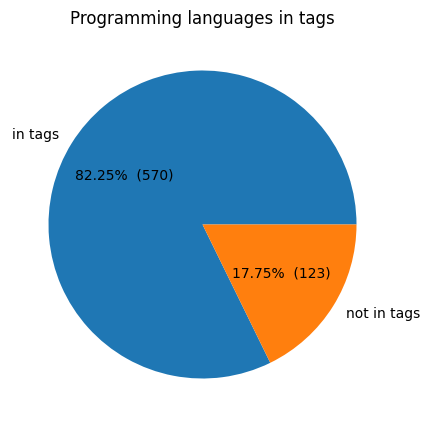

In [49]:
x = [
    len(prog_lang - tags),
    len(prog_lang & tags),
]

plt.figure(figsize=(5, 5))
plt.title(f"Programming languages in tags")
plt.pie(
    x,
    labels=["in tags", "not in tags"],
    autopct=make_autopct(x),
)

plt.show()

## <a id='toc4_7_'></a>[Nuages de mots](#toc0_)

### Pour les tags

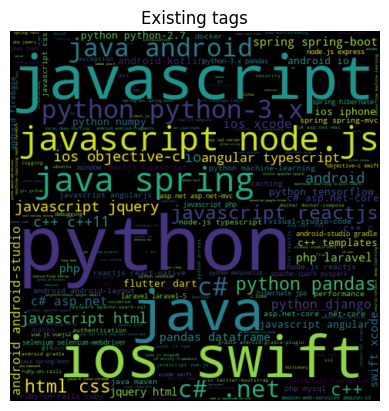

In [50]:
# assemble everything in a long string
long_string = " ".join(tags_list)

# wordcloud whole string
wordcloud = WordCloud(
    width=480,
    height=480,
    margin=0,
    stopwords=None,
    regexp=r"\S+",
).generate(long_string)

# display
plt.title("Existing tags")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [51]:
dict(sorted(wordcloud.words_.items(), key=lambda item: item[1])[:-21:-1])

{'python': 1.0,
 'javascript': 0.8362507058159232,
 'ios swift': 0.7204968944099379,
 'java': 0.6725014116318464,
 'javascript node.js': 0.6245059288537549,
 'java spring': 0.6222473178994918,
 'python python-3.x': 0.5804630152456239,
 'java android': 0.5663466967814794,
 'c#': 0.5607001693958216,
 'c# .net': 0.49632975719932243,
 'javascript reactjs': 0.45736871823828346,
 'c++': 0.3749294184076793,
 'html css': 0.37323546019198195,
 'python pandas': 0.36645962732919257,
 'javascript jquery': 0.34839073969508755,
 'javascript html': 0.3455674760022586,
 'c++ c++11': 0.33258046301524563,
 'android': 0.3286278938452851,
 'io': 0.32298136645962733,
 'ios objective-c': 0.3167701863354037}

### Pour les titres

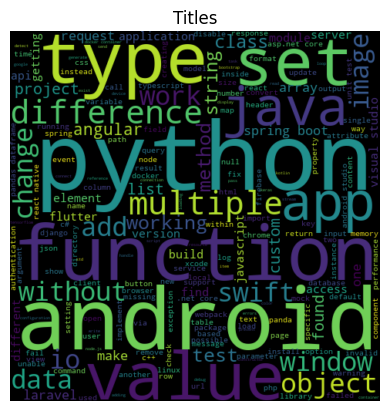

In [52]:
# assemble everything in a long string
long_string = " ".join(title_list)

# wordcloud whole string
wordcloud = WordCloud(
    width=480,
    height=480,
    margin=0,
    stopwords=None,
    regexp=r"\S+",
).generate(long_string)

# display
plt.title("Titles")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [53]:
dict(sorted(wordcloud.words_.items(), key=lambda item: item[1])[:-21:-1])

{'python': 1.0,
 'android': 0.8131868131868132,
 'function': 0.6263736263736264,
 'type': 0.5539754363283775,
 'set': 0.5371687136393019,
 'value': 0.5371687136393019,
 'java': 0.5171299288946348,
 'app': 0.513251454427925,
 'difference': 0.5100193923723335,
 'multiple': 0.5016160310277957,
 'object': 0.48868778280542985,
 'without': 0.46994182288299935,
 'io': 0.46153846153846156,
 'data': 0.4563671622495152,
 'work': 0.4557207498383969,
 'add': 0.4544279250161603,
 'image': 0.4473173884938591,
 'window': 0.4350355526826115,
 'change': 0.4350355526826115,
 'swift': 0.43244990303813835}

### Pour les corps de texte et le corpus

Le noyau Jupyter ne peut pas assumer la gestion d'une telle chaîne de caractère, trop longue.